In [24]:
import pandas as pd
import numpy as np
from datetime import datetime
from sdv import SDV
from sdv import Metadata
from sdv.evaluation import evaluate

from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.datasets.movielens import get_movielens
from implicit.lmf import LogisticMatrixFactorization
from implicit.nearest_neighbours import (BM25Recommender, CosineRecommender,
                                         TFIDFRecommender, bm25_weight)
from implicit.evaluation import ranking_metrics_at_k, train_test_split
from datetime import datetime

import os
os.environ['TQDM_DISABLE'] = '1'

In [25]:
ml_csv = r"/Users/micha/git/training/ratings_2.csv"     #100k MovieLens
#ml_csv = 'ml-100k/ratings.csv'

In [26]:
df = pd.read_csv(ml_csv)

# create a `rating_id` field, unique for each rating
df['rating_id'] = range(len(df))

# and turn the timestamps into datetimes
time_fmt = "%Y-%m-%d %H:%M:%S"
df.timestamp = df.timestamp.apply(lambda x: datetime.fromtimestamp(x))

df.head(2)

,userId,movieId,rating,timestamp,rating_id
0,196,242,3,1997-12-04 15:55:49,0
1,186,302,3,1998-04-04 20:22:22,1


Now we'll remove the column timestamp from the dataset.

In [27]:
tables = {
    'ratings': pd.DataFrame({'rating_id': df.rating_id, 'rating': df.rating, 
                             'timestamp': df.timestamp, 
                             'movieId': df.movieId, 'userId': df.userId})
}

metadata = {
    'tables': {
        'ratings': {
            'primary_key': 'rating_id',
            'fields': {
                'rating_id': {
                    'type': 'id',
                    'subtype': 'integer'
                },
                'rating': {
                    'type': 'categorical',
                    #'subtype': 'integer'
                },
                'timestamp': {
                    'type': 'datetime',
                    'format': time_fmt,
                },
                'userId': {
                    'type': 'categorical',
                    #'subtype': 'integer',
                },
                'movieId': {
                    'type': 'categorical',
                    #'subtype': 'integer',
                }
            }
        } 
    }
}

metadata = Metadata(metadata)

In [29]:
sdv = SDV()
sdv.fit(metadata, tables)

In [ ]:
samples = sdv.sample('ratings', int(0.5*len(df)), reset_primary_keys=True)   #why 0.5*len
res = evaluate(samples, real=tables, metadata=sdv.metadata)
print(res)

In [113]:
res.to_dict()

{'mse': {0: 6.513223574144483e-06},
 'r2_score': {0: 0.9321214489717161},
 'rmse': {0: 0.0025521017954118685}}

In [115]:
samples['ratings']

,rating_id,rating,timestamp,userId,movieId
0,0,5,1998-01-21 07:49:48.415720320,479,117
1,1,5,1997-10-29 16:40:48.209831296,168,603
2,2,3,1998-02-13 19:24:52.073470080,374,335
3,3,3,1997-11-01 13:52:43.170262528,264,458
4,4,4,1998-05-03 02:59:28.365404928,347,222
...,...,...,...,...,...
49995,49995,4,1997-12-22 16:37:32.154622080,719,202
49996,49996,1,1997-10-12 17:44:53.345183104,264,258
49997,49997,3,1997-08-05 13:01:27.743409024,221,147
49998,49998,4,1997-11-30 04:42:38.786087424,854,302


#### Replace rating with 1.0 and run implicit on the data

In [90]:
from surprise import Reader, Dataset
from surprise import SVD, accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

In [90]:
reader = Reader()
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size = 0.3)
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.9450
0.944950513373212


In [91]:
reader = Reader()
data = Dataset.load_from_df(samples['ratings'][['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size = 0.3)
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.9894
0.9894312599152958


This is pretty good- with Surprise SVD we get

Real RMSE: 0.9450
Synthetic RMSE: 0.9894

In [100]:
from scipy import sparse

def preprocess_movie_lens(ratings_df):
    """Separate the rating datafram into train and test sets.

    Filters out users with less than two distinct timestamps. Creates train set
    and test set. The test set contains all the last interactions of users with
    more than two distinct timestamps.

    Args:
      ratings_df: pandas dataframe with columns 'userId', 'movieId', 'rating',
        'timestamp'.

    Returns:
      tuple of dataframes (filtered_ratings, train_ratings, test_ratings).
    """
    ratings_df["data"] = 1.0
    num_timestamps = ratings_df[["userId", "timestamp"]].groupby(
        "userId").nunique()
    last_user_timestamp = ratings_df[["userId", "timestamp"]].groupby(
        "userId").max()

    ratings_df["numberOfTimestamps"] = ratings_df["userId"].apply(
        lambda x: num_timestamps["timestamp"][x])
    ratings_df["lastTimestamp"] = ratings_df["userId"].apply(
        lambda x: last_user_timestamp["timestamp"][x])

    ratings_df = ratings_df[ratings_df["numberOfTimestamps"] > 2]

    ratings_df = create_row_col_indices(ratings_df)

    train_ratings_df = ratings_df[
        ratings_df["timestamp"] < ratings_df["lastTimestamp"]]
    test_ratings_df = ratings_df[
        ratings_df["timestamp"] == ratings_df["lastTimestamp"]]

    return ratings_df, train_ratings_df, test_ratings_df

def create_index(df, colname):
    value_set = sorted(set(df[colname].values))
    num_unique = len(value_set)
    return dict(zip(value_set, range(num_unique)))

def create_row_col_indices(ratings_df):
    """Maps user and items ids to their locations in the rating matrix."""
    user_id_to_user_idx = create_index(ratings_df, "userId")
    item_id_to_item_idx = create_index(ratings_df, "movieId")

    ratings_df["row"] = ratings_df["userId"].apply(
        lambda x: user_id_to_user_idx[x])
    ratings_df["col"] = ratings_df["movieId"].apply(
        lambda x: item_id_to_item_idx[x])

    return ratings_df

def describe_rating_df(df, df_name=""):
    num_ratings = len(df)
    num_users = len(set(df["row"].values))
    num_items = len(set(df["col"].values))

    return num_users, num_items, num_ratings

def convert_df_to_sparse_matrix(df, shape=None, row_name="row", col_name="col",
                                data_name="data"):
    row = df[row_name].values
    col = df[col_name].values
    data = df[data_name].values

    return sparse.csr_matrix((data, (row, col)), shape=shape)


ratings_df, train_ratings_df, test_ratings_df = preprocess_movie_lens(df)
num_users, num_items, _ = describe_rating_df(ratings_df, "original set")

train_ratings_matrix = convert_df_to_sparse_matrix(train_ratings_df, shape=(num_users, num_items))
test_ratings_matrix = convert_df_to_sparse_matrix(test_ratings_df, shape=(num_users, num_items))

In [97]:
len(ratings_df), len(train_ratings_df), len(test_ratings_df)

(100000, 97852, 2148)

In [101]:
train_ratings_matrix.shape, test_ratings_matrix.shape

((943, 1682), (943, 1682))

In [109]:
train_ratings_matrix

<943x1682 sparse matrix of type '<class 'numpy.float64'>'
	with 97852 stored elements in Compressed Sparse Row format>

In [108]:
model = AlternatingLeastSquares(factors=100, regularization=0.01, iterations=500, num_threads=40)
model.fit(train_ratings_matrix.T)
    
res = ranking_metrics_at_k(model, train_ratings_matrix, test_ratings_matrix, K=20, num_threads=40)
print(f'n_users = {train_ratings_matrix.shape[0]}, n_items = {train_ratings_matrix.shape[1]}')
print(f'results: {res}')


n_users = 943, n_items = 1682
results: {'precision': 0.23649906890130354, 'map': 0.05121547791430991, 'ndcg': 0.09998833803148777, 'auc': 0.5885126367078413}


In [135]:
import traceback
sdv = SDV()
sdv.fit(metadata, tables)

res = {}
for n in (2**x for x in range(8,24)):
    try:
        print(n)
        res['n'] = n
        samples = sdv.sample('ratings', n, reset_primary_keys=True)
        sdv_res = evaluate(samples, real=tables, metadata=sdv.metadata)
        res['sdv_mse'] = sdv_res['mse'].values[0]
        res['sdv_r2_score'] = sdv_res['r2_score'].values[0]
        res['sdv_rmse'] = sdv_res['rmse'].values[0]

        ratings_df, train_ratings_df, test_ratings_df = preprocess_movie_lens(samples['ratings'])
        num_users, num_items, num_ratings = describe_rating_df(ratings_df, "original set")

        train_ratings_matrix = convert_df_to_sparse_matrix(train_ratings_df, shape=(num_users, num_items))
        test_ratings_matrix = convert_df_to_sparse_matrix(test_ratings_df, shape=(num_users, num_items))
        
        res['num_users'] = num_users
        res['num_items'] = num_items
        res['num_ratings'] = num_ratings
        
        model = AlternatingLeastSquares(factors=100, regularization=0.01, iterations=300, num_threads=20)
        model.fit(train_ratings_matrix.T)
    
        impl_res = ranking_metrics_at_k(model, train_ratings_matrix, test_ratings_matrix, K=50, num_threads=1)
        res.update(impl_res)
        print(res)
    except:
        print(traceback.format_exc())
        
print('final results:', res)

256


/home/aonghus/anaconda3/envs/fyp/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/aonghus/anaconda3/envs/fyp/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{'n': 256, 'sdv_mse': 7.994360032081747e-06, 'sdv_r2_score': 0.9166855598922978, 'sdv_rmse': 0.0028274299340711783, 'num_users': 5, 'num_items': 19, 'num_ratings': 19, 'precision': 1.0, 'map': 0.09833333333333333, 'ndcg': 0.2868141676552288, 'auc': 0.47777777777777775}
512



{'n': 512, 'sdv_mse': 6.784445509149238e-06, 'sdv_r2_score': 0.9292948682861869, 'sdv_rmse': 0.002604696817126561, 'num_users': 49, 'num_items': 150, 'num_ratings': 172, 'precision': 0.12244897959183673, 'map': 0.005801694854489885, 'ndcg': 0.02667018871856712, 'auc': 0.38946719627448273}
1024



{'n': 1024, 'sdv_mse': 7.497010303885454e-06, 'sdv_r2_score': 0.9218687657994756, 'sdv_rmse': 0.0027380668917843212, 'num_users': 162, 'num_items': 401, 'num_ratings': 645, 'precision': 0.05555555555555555, 'map': 0.0027074630735698, 'ndcg': 0.012374605973768868, 'auc': 0.4654166666666667}
2048



{'n': 2048, 'sdv_mse': 7.4916307394768865e-06, 'sdv_r2_score': 0.9219248297489255, 'sdv_rmse': 0.0027370843500843897, 'num_users': 304, 'num_items': 621, 'num_ratings': 1697, 'precision': 0.07894736842105263, 'map': 0.006003693231770881, 'ndcg': 0.019702450356214797, 'auc': 0.4993686332767395}
4096



{'n': 4096, 'sdv_mse': 6.136301436243091e-06, 'sdv_r2_score': 0.9360496004131611, 'sdv_rmse': 0.0024771559168213636, 'num_users': 419, 'num_items': 797, 'num_ratings': 3734, 'precision': 0.06921241050119331, 'map': 0.006989486930138349, 'ndcg': 0.0193120710931, 'auc': 0.5039487413199681}
8192



{'n': 8192, 'sdv_mse': 5.383457586683845e-06, 'sdv_r2_score': 0.9438954772016528, 'sdv_rmse': 0.002320227916969332, 'num_users': 563, 'num_items': 980, 'num_ratings': 7863, 'precision': 0.13854351687388988, 'map': 0.013018151451453035, 'ndcg': 0.0368930095260795, 'auc': 0.5442380578289776}
16384



{'n': 16384, 'sdv_mse': 6.285771908760213e-06, 'sdv_r2_score': 0.9344918711289629, 'sdv_rmse': 0.0025071441739078775, 'num_users': 687, 'num_items': 1143, 'num_ratings': 16101, 'precision': 0.09170305676855896, 'map': 0.009062243792089978, 'ndcg': 0.024543289067653542, 'auc': 0.5241309074964876}
32768



{'n': 32768, 'sdv_mse': 5.818038038092564e-06, 'sdv_r2_score': 0.9393664308682915, 'sdv_rmse': 0.002412060952399952, 'num_users': 832, 'num_items': 1247, 'num_ratings': 32613, 'precision': 0.10576923076923077, 'map': 0.01040614792098257, 'ndcg': 0.028208632350933224, 'auc': 0.5329815023459724}
65536



{'n': 65536, 'sdv_mse': 6.0367123457462245e-06, 'sdv_r2_score': 0.9370874832808684, 'sdv_rmse': 0.0024569721906741687, 'num_users': 917, 'num_items': 1394, 'num_ratings': 65492, 'precision': 0.10032715376226826, 'map': 0.010260463579067469, 'ndcg': 0.026899027985115592, 'auc': 0.5322855905951426}
131072



{'n': 131072, 'sdv_mse': 5.8393117707311955e-06, 'sdv_r2_score': 0.9391447234249595, 'sdv_rmse': 0.0024164667948745324, 'num_users': 942, 'num_items': 1513, 'num_ratings': 131071, 'precision': 0.10191082802547771, 'map': 0.009839868507143142, 'ndcg': 0.02718761814926452, 'auc': 0.5345782922746914}
262144



{'n': 262144, 'sdv_mse': 5.963963023621745e-06, 'sdv_r2_score': 0.9378456514164907, 'sdv_rmse': 0.0024421226471292848, 'num_users': 943, 'num_items': 1591, 'num_ratings': 262144, 'precision': 0.11240721102863202, 'map': 0.0123801577960425, 'ndcg': 0.030990020187902576, 'auc': 0.540602386335585}
524288



{'n': 524288, 'sdv_mse': 5.956585098634555e-06, 'sdv_r2_score': 0.937922541584934, 'sdv_rmse': 0.0024406116238833565, 'num_users': 943, 'num_items': 1650, 'num_ratings': 524288, 'precision': 0.10392364793213149, 'map': 0.0101421641697548, 'ndcg': 0.027494740265647827, 'auc': 0.5368165545235579}
1048576



{'n': 1048576, 'sdv_mse': 6.01089250462614e-06, 'sdv_r2_score': 0.9373565686858236, 'sdv_rmse': 0.0024517121577840536, 'num_users': 943, 'num_items': 1680, 'num_ratings': 1048576, 'precision': 0.088016967126193, 'map': 0.008492477613682539, 'ndcg': 0.023338082496882254, 'auc': 0.5291174050099167}
2097152



{'n': 2097152, 'sdv_mse': 6.000860127822438e-06, 'sdv_r2_score': 0.9374611226279773, 'sdv_rmse': 0.0024496653093478787, 'num_users': 943, 'num_items': 1682, 'num_ratings': 2097152, 'precision': 0.07317073170731707, 'map': 0.006853477823710734, 'ndcg': 0.01940530582978686, 'auc': 0.5218261866295483}
4194304



{'n': 4194304, 'sdv_mse': 5.976360792554932e-06, 'sdv_r2_score': 0.9377164461801606, 'sdv_rmse': 0.0024446596475900142, 'num_users': 943, 'num_items': 1682, 'num_ratings': 4194304, 'precision': 0.060445387062566275, 'map': 0.005721276973208016, 'ndcg': 0.016227942160724564, 'auc': 0.5155076732465503}
8388608



{'n': 8388608, 'sdv_mse': 6.007098286821768e-06, 'sdv_r2_score': 0.9373961107042903, 'sdv_rmse': 0.002450938246227711, 'num_users': 943, 'num_items': 1682, 'num_ratings': 8388608, 'precision': 0.03923647932131495, 'map': 0.0031422959557773117, 'ndcg': 0.00999524067086586, 'auc': 0.504826887495}
final results: {'n': 8388608, 'sdv_mse': 6.007098286821768e-06, 'sdv_r2_score': 0.9373961107042903, 'sdv_rmse': 0.002450938246227711, 'num_users': 943, 'num_items': 1682, 'num_ratings': 8388608, 'precision': 0.03923647932131495, 'map': 0.0031422959557773117, 'ndcg': 0.00999524067086586, 'auc': 0.504826887495}


In [69]:
res_json = """
[
{'n': 256, 'sdv_mse': 7.994360032081747e-06, 'sdv_r2_score': 0.9166855598922978, 'sdv_rmse': 0.0028274299340711783, 'num_users': 5, 'num_items': 19, 'num_ratings': 19, 'precision': 1.0, 'map': 0.09833333333333333, 'ndcg': 0.2868141676552288, 'auc': 0.47777777777777775},
{'n': 512, 'sdv_mse': 6.784445509149238e-06, 'sdv_r2_score': 0.9292948682861869, 'sdv_rmse': 0.002604696817126561, 'num_users': 49, 'num_items': 150, 'num_ratings': 172, 'precision': 0.12244897959183673, 'map': 0.005801694854489885, 'ndcg': 0.02667018871856712, 'auc': 0.38946719627448273},
{'n': 1024, 'sdv_mse': 7.497010303885454e-06, 'sdv_r2_score': 0.9218687657994756, 'sdv_rmse': 0.0027380668917843212, 'num_users': 162, 'num_items': 401, 'num_ratings': 645, 'precision': 0.05555555555555555, 'map': 0.0027074630735698, 'ndcg': 0.012374605973768868, 'auc': 0.4654166666666667},
{'n': 2048, 'sdv_mse': 7.4916307394768865e-06, 'sdv_r2_score': 0.9219248297489255, 'sdv_rmse': 0.0027370843500843897, 'num_users': 304, 'num_items': 621, 'num_ratings': 1697, 'precision': 0.07894736842105263, 'map': 0.006003693231770881, 'ndcg': 0.019702450356214797, 'auc': 0.4993686332767395},
{'n': 4096, 'sdv_mse': 6.136301436243091e-06, 'sdv_r2_score': 0.9360496004131611, 'sdv_rmse': 0.0024771559168213636, 'num_users': 419, 'num_items': 797, 'num_ratings': 3734, 'precision': 0.06921241050119331, 'map': 0.006989486930138349, 'ndcg': 0.0193120710931, 'auc': 0.5039487413199681},
{'n': 8192, 'sdv_mse': 5.383457586683845e-06, 'sdv_r2_score': 0.9438954772016528, 'sdv_rmse': 0.002320227916969332, 'num_users': 563, 'num_items': 980, 'num_ratings': 7863, 'precision': 0.13854351687388988, 'map': 0.013018151451453035, 'ndcg': 0.0368930095260795, 'auc': 0.5442380578289776},
{'n': 16384, 'sdv_mse': 6.285771908760213e-06, 'sdv_r2_score': 0.9344918711289629, 'sdv_rmse': 0.0025071441739078775, 'num_users': 687, 'num_items': 1143, 'num_ratings': 16101, 'precision': 0.09170305676855896, 'map': 0.009062243792089978, 'ndcg': 0.024543289067653542, 'auc': 0.5241309074964876},
{'n': 32768, 'sdv_mse': 5.818038038092564e-06, 'sdv_r2_score': 0.9393664308682915, 'sdv_rmse': 0.002412060952399952, 'num_users': 832, 'num_items': 1247, 'num_ratings': 32613, 'precision': 0.10576923076923077, 'map': 0.01040614792098257, 'ndcg': 0.028208632350933224, 'auc': 0.5329815023459724},
{'n': 65536, 'sdv_mse': 6.0367123457462245e-06, 'sdv_r2_score': 0.9370874832808684, 'sdv_rmse': 0.0024569721906741687, 'num_users': 917, 'num_items': 1394, 'num_ratings': 65492, 'precision': 0.10032715376226826, 'map': 0.010260463579067469, 'ndcg': 0.026899027985115592, 'auc': 0.5322855905951426},
{'n': 131072, 'sdv_mse': 5.8393117707311955e-06, 'sdv_r2_score': 0.9391447234249595, 'sdv_rmse': 0.0024164667948745324, 'num_users': 942, 'num_items': 1513, 'num_ratings': 131071, 'precision': 0.10191082802547771, 'map': 0.009839868507143142, 'ndcg': 0.02718761814926452, 'auc': 0.5345782922746914},
{'n': 262144, 'sdv_mse': 5.963963023621745e-06, 'sdv_r2_score': 0.9378456514164907, 'sdv_rmse': 0.0024421226471292848, 'num_users': 943, 'num_items': 1591, 'num_ratings': 262144, 'precision': 0.11240721102863202, 'map': 0.0123801577960425, 'ndcg': 0.030990020187902576, 'auc': 0.540602386335585},
{'n': 524288, 'sdv_mse': 5.956585098634555e-06, 'sdv_r2_score': 0.937922541584934, 'sdv_rmse': 0.0024406116238833565, 'num_users': 943, 'num_items': 1650, 'num_ratings': 524288, 'precision': 0.10392364793213149, 'map': 0.0101421641697548, 'ndcg': 0.027494740265647827, 'auc': 0.5368165545235579},
{'n': 1048576, 'sdv_mse': 6.01089250462614e-06, 'sdv_r2_score': 0.9373565686858236, 'sdv_rmse': 0.0024517121577840536, 'num_users': 943, 'num_items': 1680, 'num_ratings': 1048576, 'precision': 0.088016967126193, 'map': 0.008492477613682539, 'ndcg': 0.023338082496882254, 'auc': 0.5291174050099167},
{'n': 2097152, 'sdv_mse': 6.000860127822438e-06, 'sdv_r2_score': 0.9374611226279773, 'sdv_rmse': 0.0024496653093478787, 'num_users': 943, 'num_items': 1682, 'num_ratings': 2097152, 'precision': 0.07317073170731707, 'map': 0.006853477823710734, 'ndcg': 0.01940530582978686, 'auc': 0.5218261866295483},
{'n': 4194304, 'sdv_mse': 5.976360792554932e-06, 'sdv_r2_score': 0.9377164461801606, 'sdv_rmse': 0.0024446596475900142, 'num_users': 943, 'num_items': 1682, 'num_ratings': 4194304, 'precision': 0.060445387062566275, 'map': 0.005721276973208016, 'ndcg': 0.016227942160724564, 'auc': 0.5155076732465503},
{'n': 8388608, 'sdv_mse': 6.007098286821768e-06, 'sdv_r2_score': 0.9373961107042903, 'sdv_rmse': 0.002450938246227711, 'num_users': 943, 'num_items': 1682, 'num_ratings': 8388608, 'precision': 0.03923647932131495, 'map': 0.0031422959557773117, 'ndcg': 0.00999524067086586, 'auc': 0.504826887495}
]
""".replace('\'', '\"')
import json
#json.loads(res_json)
sdv_res = pd.read_json(res_json)

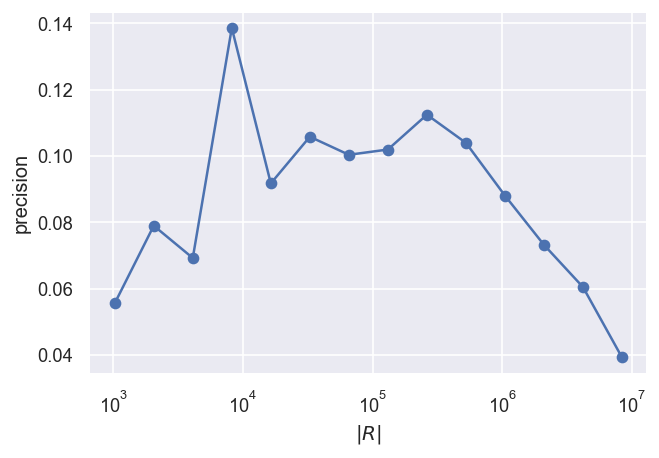

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set(rc={'figure.dpi': 120})
#sdv_res.plot(x='n', y='precision')
plt.plot(sdv_res[sdv_res.n >= 1024]['n'], sdv_res[sdv_res.n >= 1024]['precision'], marker='o')
plt.xlabel('$|R|$')
plt.ylabel('precision')
plt.xscale('log')

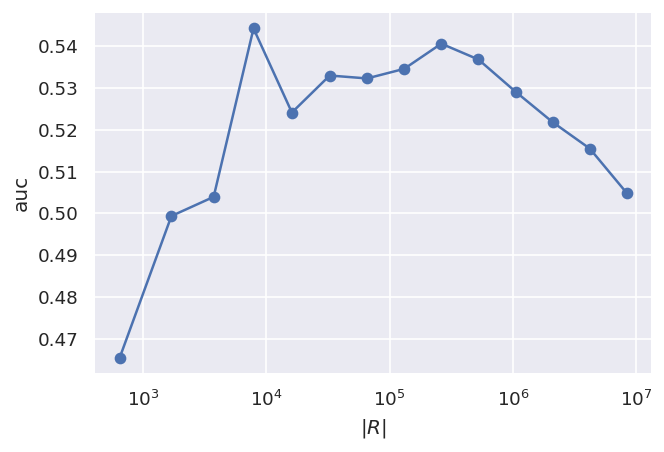

In [186]:
#sdv_res.plot(x='n', y='precision')
plt.plot(sdv_res[sdv_res.n > 1000]['num_ratings'], sdv_res[sdv_res.n > 1000]['auc'], marker='o')
plt.xlabel('$|R|$')
plt.ylabel('auc')
plt.xscale('log')

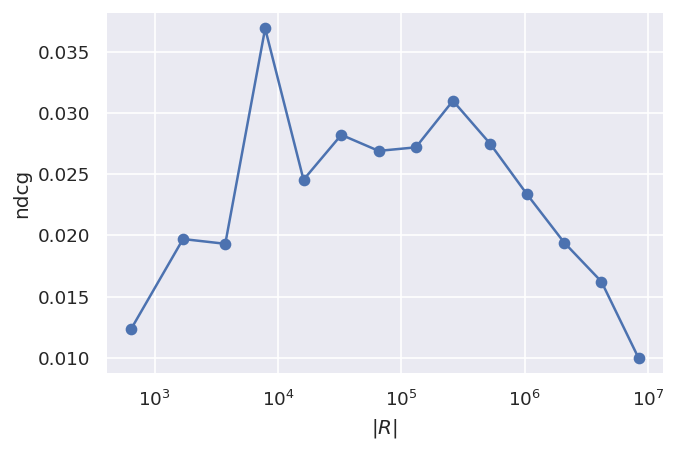

In [187]:
plt.plot(sdv_res[sdv_res.n > 1000]['num_ratings'], sdv_res[sdv_res.n > 1000]['ndcg'], marker='o')
plt.xlabel('$|R|$')
plt.ylabel('ndcg')
plt.xscale('log')

In [174]:
sdv_res

,n,sdv_mse,sdv_r2_score,sdv_rmse,num_users,num_items,num_ratings,precision,map,ndcg,auc
0,256,0.000008,0.916686,0.002827,5,19,19,1.000000,0.098333,0.286814,0.477778
1,512,0.000007,0.929295,0.002605,49,150,172,0.122449,0.005802,0.026670,0.389467
2,1024,0.000007,0.921869,0.002738,162,401,645,0.055556,0.002707,0.012375,0.465417
3,2048,0.000007,0.921925,0.002737,304,621,1697,0.078947,0.006004,0.019702,0.499369
4,4096,0.000006,0.936050,0.002477,419,797,3734,0.069212,0.006989,0.019312,0.503949
5,8192,0.000005,0.943895,0.002320,563,980,7863,0.138544,0.013018,0.036893,0.544238
6,16384,0.000006,0.934492,0.002507,687,1143,16101,0.091703,0.009062,0.024543,0.524131
7,32768,0.000006,0.939366,0.002412,832,1247,32613,0.105769,0.010406,0.028209,0.532982
8,65536,0.000006,0.937087,0.002457,917,1394,65492,0.100327,0.010260,0.026899,0.532286
9,131072,0.000006,0.939145,0.002416,942,1513,131071,0.101911,0.009840,0.027188,0.534578


In [31]:
sdv_df = pd.read_pickle('sdv_res.pkl')
sdv_df

,n,sdv_mse,sdv_r2_score,sdv_rmse,num_users,num_items,num_ratings,precision,map,ndcg,auc
0,256,0.000008,0.916686,0.002827,5,19,19,1.000000,0.098333,0.286814,0.477778
1,512,0.000007,0.929295,0.002605,49,150,172,0.122449,0.005802,0.026670,0.389467
2,1024,0.000007,0.921869,0.002738,162,401,645,0.055556,0.002707,0.012375,0.465417
3,2048,0.000007,0.921925,0.002737,304,621,1697,0.078947,0.006004,0.019702,0.499369
4,4096,0.000006,0.936050,0.002477,419,797,3734,0.069212,0.006989,0.019312,0.503949
5,8192,0.000005,0.943895,0.002320,563,980,7863,0.138544,0.013018,0.036893,0.544238
6,16384,0.000006,0.934492,0.002507,687,1143,16101,0.091703,0.009062,0.024543,0.524131
7,32768,0.000006,0.939366,0.002412,832,1247,32613,0.105769,0.010406,0.028209,0.532982
8,65536,0.000006,0.937087,0.002457,917,1394,65492,0.100327,0.010260,0.026899,0.532286
9,131072,0.000006,0.939145,0.002416,942,1513,131071,0.101911,0.009840,0.027188,0.534578


Text(0.5, 1.0, 'Precision Results for 100k using SDV')

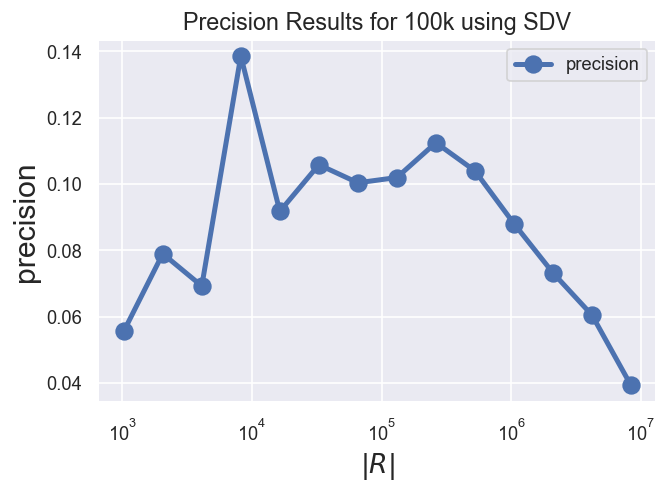

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set(rc={'figure.dpi': 120})
#sdv_res.plot(x='n', y='precision')                                         
plt.plot(sdv_df[sdv_df.n >= 1024]['n'], sdv_df[sdv_df.n >= 1024]['precision'], marker='o', linewidth=3, markersize=10, label = 'precision')
plt.xlabel('$|R|$', fontsize=16)
plt.ylabel('precision', fontsize=18)
plt.xscale('log')
plt.legend(loc=1)
plt.title("Precision Results for 100k using SDV", fontsize=14)


Text(0.5, 1.0, 'MAP Results for 100k using SDV')

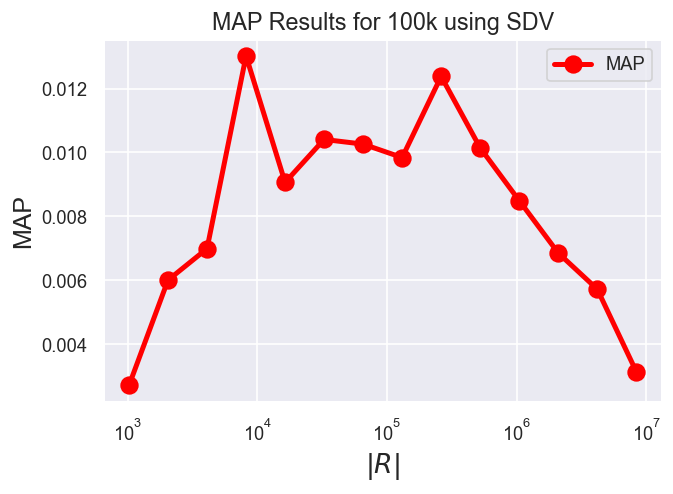

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set(rc={'figure.dpi': 120})
#sdv_res.plot(x='n', y='precision')                                         
plt.plot(sdv_df[sdv_df.n >= 1024]['n'], sdv_df[sdv_df.n >= 1024]['map'], marker='o', color='red', linewidth=3, markersize=10, label = 'MAP')
plt.xlabel('$|R|$', fontsize=16)
plt.ylabel('MAP', fontsize=15)
plt.xscale('log')
plt.legend(loc=1)
plt.title("MAP Results for 100k using SDV", fontsize=14)


Text(0.5, 1.0, 'nDCG Results for 100k using SDV')

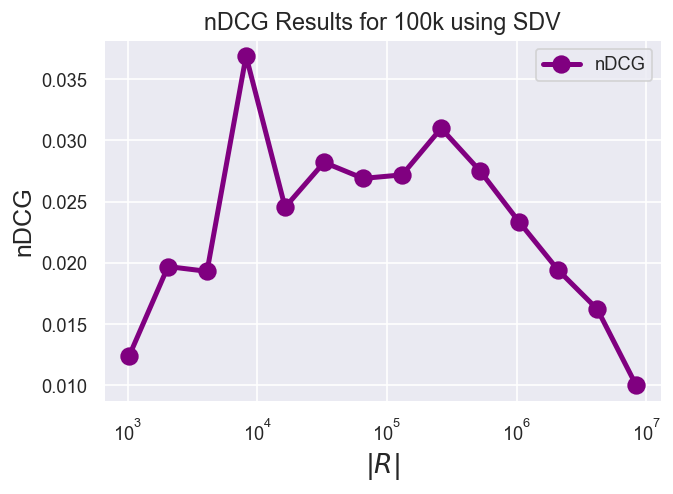

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set(rc={'figure.dpi': 120})
#sdv_res.plot(x='n', y='precision')                                         
plt.plot(sdv_df[sdv_df.n >= 1024]['n'], sdv_df[sdv_df.n >= 1024]['ndcg'], marker='o', color='purple', linewidth=3, markersize=10, label = 'nDCG')
plt.xlabel('$|R|$', fontsize=16)
plt.ylabel('nDCG', fontsize=15)
plt.xscale('log')
plt.legend(loc=1)
plt.title("nDCG Results for 100k using SDV", fontsize=14)


### RMSE 

Text(0.5, 1.0, 'RMSE Results for 100k using SDV')

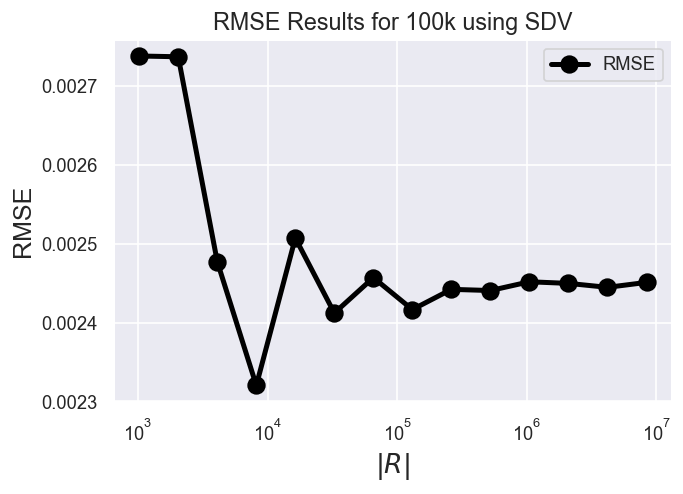

In [76]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set(rc={'figure.dpi': 120})
#sdv_res.plot(x='n', y='precision')                                         
plt.plot(sdv_df[sdv_df.n >= 1024]['n'], sdv_df[sdv_df.n >= 1024]['sdv_rmse'], marker='o', color='black', linewidth=3, markersize=10, label = 'RMSE')
plt.xlabel('$|R|$', fontsize=16)
plt.ylabel('RMSE', fontsize=15)
plt.xscale('log')
plt.legend(loc=1)
plt.title("RMSE Results for 100k using SDV", fontsize=14)
